In [3]:
import pandas as pd
import torch
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
companies_df = pd.read_csv(
  "../data/companies_cleaned.csv", usecols=["name"]
)

companies = companies_df.name.to_list()

In [5]:
len(companies)

126021

In [6]:
companies[:5]

['ibm', 'walmart', 'microsoft', 'pwc', 'deloitte']

In [7]:
min([len(c) for c in companies])

2

In [8]:
max([len(c) for c in companies])

20

In [9]:
sum([len(c) for c in companies]) / len(companies)

8.524261829377643

In [10]:
alphabet = sorted(set("".join(companies)))
alphabet.insert(0, '.')
len_alphabet = len(alphabet)
len_alphabet

27

In [11]:
import itertools

In [12]:
combinations = list(itertools.product(alphabet, repeat=2))
combinations = [''.join(comb) for comb in combinations]

In [13]:
len(combinations)

729

In [14]:
strtoint = {j: i for i, j in enumerate(alphabet)}
inttostr = {i: j for i, j in enumerate(alphabet)}

In [15]:
strtoint_bi = {j: i for i, j in enumerate(combinations)}
inttostr_bi = {i: j for i, j in enumerate(combinations)}

In [16]:
E = torch.zeros((len(alphabet) * len(alphabet), len(alphabet)), dtype=torch.int32)

In [17]:
E.shape

torch.Size([729, 27])

In [18]:
import tqdm

In [19]:
# word = "openai"
for word in tqdm.tqdm(companies):  
  word = ['.', '.'] + list(word) + ['.']
  for ch1, ch2, ch3 in zip(word, word[1:], word[2:]):
    int1, int2, int3 = strtoint[ch1], strtoint[ch2], strtoint[ch3]
    int12 = strtoint_bi[ch1+ch2]
    E[int12, int3] += 1
#     print(ch1, ch2, ch3)
#     print(int1, int2, int3)

100%|████████████████████████████████████████████████| 126021/126021 [00:14<00:00, 8602.75it/s]


In [20]:
E

tensor([[   0, 9230, 6901,  ...,  592,  809, 1272],
        [   0,  107,  240,  ...,  114,   37,   84],
        [   0,  907,   37,  ...,    3,   84,    1],
        ...,
        [   1,    0,    0,  ...,    0,    0,    1],
        [  75,    1,    8,  ...,    2,    1,    0],
        [  95,   63,   11,  ...,    0,   26,    7]], dtype=torch.int32)

In [21]:
E.shape

torch.Size([729, 27])

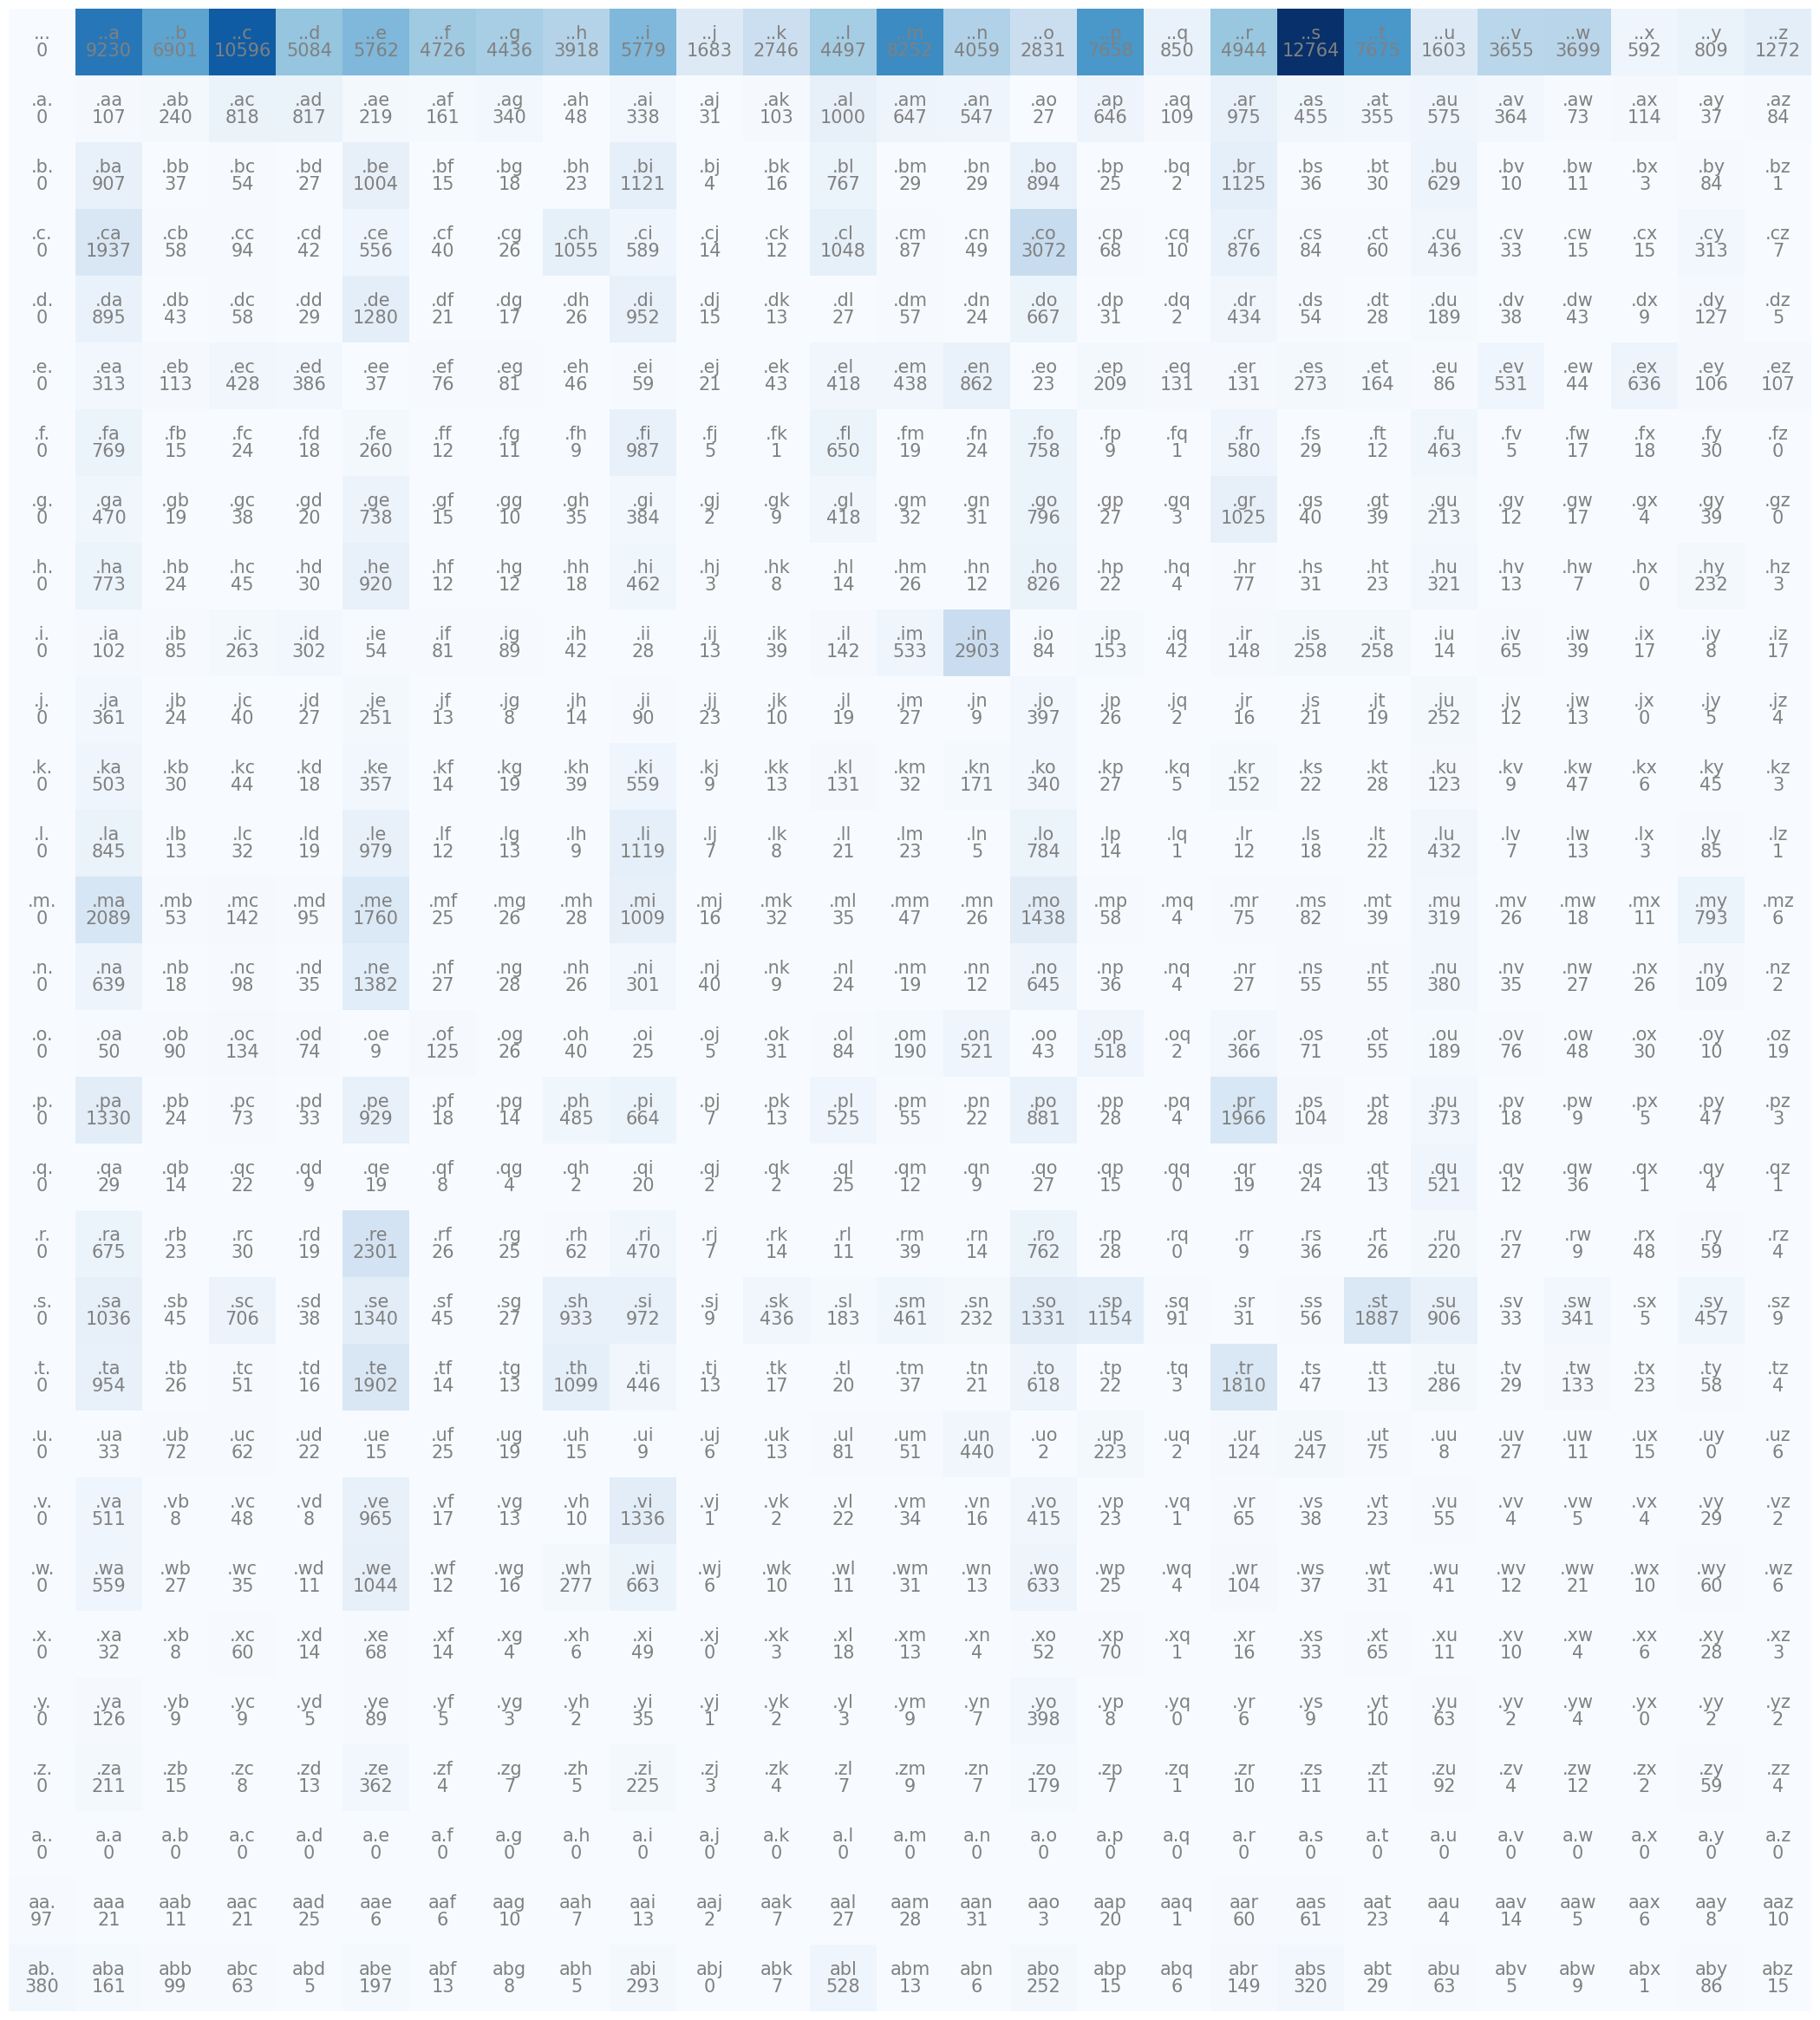

In [550]:
# 655 is because of the figsize parameter limit which is 2**16

# comment out below line to visualize all the trigrams (takes some time) 
# trc = 655
trc = 30

plt.figure(figsize=(27, trc))
plt.imshow(E[:trc, :], cmap='Blues')

for yy, row in enumerate(E[:trc, :]):
    for x, val in enumerate(row):
        plt.text(x, yy, f"{val}", va='top', ha='center', color='gray', fontsize=15)
        plt.text(x, yy, f"{inttostr_bi[yy] + inttostr[x]}", va='bottom', ha='center', color='gray', fontsize=15)
plt.axis('off');

In [480]:
2**16

65536

In [365]:
E[0, :]

tensor([    0,  9230,  6901, 10596,  5084,  5762,  4726,  4436,  3918,  5779,
         1683,  2746,  4497,  8252,  4059,  2831,  7658,   850,  4944, 12764,
         7675,  1603,  3655,  3699,   592,   809,  1272], dtype=torch.int32)

In [366]:
p = E[0].float()
p = p / p.sum()
p

tensor([0.0000, 0.0732, 0.0548, 0.0841, 0.0403, 0.0457, 0.0375, 0.0352, 0.0311,
        0.0459, 0.0134, 0.0218, 0.0357, 0.0655, 0.0322, 0.0225, 0.0608, 0.0067,
        0.0392, 0.1013, 0.0609, 0.0127, 0.0290, 0.0294, 0.0047, 0.0064, 0.0101])

In [367]:
g = torch.Generator().manual_seed(10110609)
samples = torch.multinomial(p, 20, replacement=True, generator=g)

chs = []
for s in samples:
  ch = inttostr[s.item()]
  chs.append(ch)
sorted(chs)

['a',
 'b',
 'b',
 'c',
 'c',
 'c',
 'd',
 'g',
 'h',
 'm',
 'm',
 'm',
 'n',
 'p',
 'p',
 's',
 't',
 't',
 't',
 'v']

In [23]:
P = (E+1).float() # +1 is for model smoothing
P /= P.sum(axis=1, keepdims=True)

In [ ]:
# model smoothing paper reference:
  # 

In [24]:
P.shape

torch.Size([729, 27])

In [25]:
# normalized each row to be probability. Each row sums to one.
(P[0, :]).sum()

tensor(1.)

In [29]:
P.dtype

torch.float32

In [32]:
# sampling from the model
g = torch.Generator().manual_seed(10110609)
samples = []

for i in range(20):
    letters = '..'

    word = ''

    while True:
        idx = strtoint_bi[letters]
        # p = E[idx].float()
        # p = p / p.sum()
        p = P[idx]
        next_letter_ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g)
        letter = inttostr[next_letter_ix.item()]

        if letter == '.':
            break

        word += letter
        letters = letters[1:] + letter

    samples.append(word)
    print(word)

tievervidealna
prel
aydoc
mg
all
ustcancents
bolowdrbira
frity
trab
brads
seloolom
vlics
vil
reelesto
tend
er
zstecoalions
mmgp
el
daian


In [33]:
# samples that exist in the training data
[w for w in samples if w in companies]

['tend']

In [520]:
# compute the loss on the entire dataset or a single string

n = 0
log_likelihood = 0

# for word in ["openai"]:
for word in companies:
  word = ['.', '.'] + list(word) + ['.']
  for ch1, ch2, ch3 in zip(word, word[1:], word[2:]):
    ix1 = strtoint_bi[ch1+ch2]
    ix2 = strtoint[ch3]
    prob = P[ix1, ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1

print(f"{log_likelihood=}")
neg_logl = -log_likelihood
print(f"{neg_logl=}")
loss = neg_logl/n
print(f"{loss=}")

log_likelihood=tensor(-2969004.)
neg_logl=tensor(2969004.)
loss=tensor(2.4736)


In [454]:
# increase the probability of the trigrams
# increase the loglikelihood
# decrease the negative loglikelihood
# decrease the average negative loglikelihood = decrease the loss

In [521]:
def build_dataset(words):
  xs, ys = [], []
  for word in words:
    word = ['.', '.'] + list(word) + ['.']
    for ch1, ch2, ch3 in zip(word, word[1:], word[2:]):
      ix1 = strtoint_bi[ch1+ch2]
      ix2 = strtoint[ch3]
      xs.append(ix1)
      ys.append(ix2)
      
  xs = torch.tensor(xs)
  ys = torch.tensor(ys)

  return xs, ys

In [37]:
len(companies)

126021

In [525]:
companies[:5]
# propably sorted for popularity (with most employees)

['ibm', 'walmart', 'microsoft', 'pwc', 'deloitte']

In [526]:
# splitting data into train, dev and test sets
import random

random.shuffle(companies)

n1 = int(len(companies) * 0.8)
n2 = int(len(companies) * 0.9)

X_train, y_train = build_dataset(companies[:n1]) # 80% train
X_dev, y_dev = build_dataset(companies[n1:n2]) # 10% dev
X_test, y_test = build_dataset(companies[n2:]) # 10% test

In [528]:
len(X_train), len(X_dev), len(X_test)

(960443, 119982, 119832)

In [531]:
import torch.nn.functional as F

W = torch.randn((num_letters*num_letters, num_letters), requires_grad=True).float()
batch_size = 74

In [532]:
W.shape

torch.Size([729, 27])

In [533]:
reg_params = torch.linspace(-3, 1, 10)

In [35]:
reg_params

NameError: name 'reg_params' is not defined

In [36]:
# there is a problem with the training, needs to be fixed 

regi, lossi = [], []

for reg in reg_params[:1]:
  for i in range(2000):

    # forward pass
    batchix = torch.randint(0, X_train.shape[0], (batch_size,))
    X_batch = X_train[batchix]
    y_batch = y_train[batchix]
    logits = W[X_batch]
    assert logits.shape == (batch_size, num_letters)
    loss = F.cross_entropy(logits, y_batch) + reg * (W**2).mean()

    if i % 100 == 99:
        print(f"{i}/ loss: {loss}")

    # bacward pass
    W.grad = None # reset the gradients
    loss.backward()

    # update
    lr = 50 if i < 5000 else 5
    W.data += -lr * W.grad

  # evaluate the model
  logits = W[X_dev]

  dev_loss = F.cross_entropy(logits, y_dev)
  lossi.append(dev_loss.data)
  regi.append(reg)

plt.plot(regi, lossi)

NameError: name 'reg_params' is not defined